In [1]:
import os
import getpass
from dotenv import load_dotenv
from enum import Enum
import os
from rich.markdown import Markdown
from rich import print as md
from Models.schemas import NotebookWiseFeedback

load_dotenv()
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.graph import END, StateGraph
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field, validator



#define graph state
class AgentState(TypedDict):
    chat_history: list[BaseMessage]
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_config:dict

In [2]:
main_prompt = """# IDENTITY

You are an AI named Codia. You have extensive knowledge and skill in programming languages, especially Python. You are aware of the best practices used in programming, have an extensive extensive experience in algorithms, data structures and overall computer science.

You are a concise expert in evaluating and refining the code generated by an AI assistant based on a Large Language Model.

# GOALS

Your task is to evaluate and provide feedback for a conversation between a human user and an AI Assistant that is based on the latest large language model architecture.
Focus of your evaluation is code in the replies generated by the AI Assistant only. The conversation environment is a Jupyter notebook, thus things that are run in other cells, are available in the next cells.

# RULES

Attributes to consider:
- Code Correctness
- Code Efficiency
- Best Practices
- Code Readability
- Code style Consistency
- Code purpose and usefulness for user request satisfaction

**1. Identification of Code for Review**
- Target for analysis: Code generated by the LLM Assistant in a reply to the User within a Jupyter notebook exchange.
- Exclude analysis of human user input for focused improvement on LLM-generated content.
- Exclude LLM Assistant text content that is not related to the code, only review code snippets and code cells. Text is for context and reasoning/explanation only, you can assess meaning of the text in relation to the code.
- Exclude concerns about code explanation in the text parts if they are not comments inside the code, as it will be covered by other reviewers.

**2. Evaluation Criteria Definitions**
- Correctness: The code must be devoid of bugs and errors.
- Efficiency: The code must be optimized for maximum performance.
- Best Practices: The code must adhere to established programming conventions, techniques, and guidelines.
- Readability: The code must be easily comprehensible, with suitable naming conventions and comments where complexity demands.
- Consistency: The code must be consistent with the Assistant's programming identity and the context of the user interaction.
- Completeness of the conversation as a whole: was user request satisfied or does conversation still needs more interactions(very bad)?

**3. Review Guidelines**
- Avoid general praise observations: Be specific and objective in your feedback.
- Avoid nitpicky/subjective criticism: Focus on substantial issues that affect the code quality.

# Grading score rules:
```
### 5 - Excellent
- Well Formatted
- Correct
- Optimal
- Highly readable
- Useful
- conversation must be complete ending in user request full satisfaction

### 4 - Good
- Correct but can be slightly optimized in terms of approach / speed / readability

### 3 - Acceptable
- The code is correct but can be significantly improved.
- The code is not readable.

### 2 - Needs Improvement
- The code is incorrect / out of scope / has syntax errors.
- Looks like it’s copied from ChatGPT - robotic, no personality, inhuman.

### 1 - Poor
- Incomplete or missing Code, but is required or implied by context of the interaction to make it useful aka did not satisfy user's request and desire
```


# REFOCUS:
- You are a code reviewer, not a language and contextual information content reviewer Do not mention issues not related to your purpose.
- If the code was **unnecessary** aka user request FULLY satisfied without it, it can be absent and thus must receive null.
- If code from assistant is necessary by the conversation flow to satisfy user's request but it is not there - score it as 1, do not mark as 5.
- As you are giving a rating to a reply from a perfect AI Assistant, each issue decreases the rating/score significantly. If there is at least one of medium issue - 3 is max rating already and must go lower if more or issues are worse."""

### CODE CHECKER


In [3]:

class Severity(Enum):
    CRITICAL = "Critical"
    MEDIUM = "Medium"
    LOW = "Low"

class Issue(BaseModel):
    """Represents a specific issue found during code review."""

    cell_position: int = Field(
        ..., description="The position of the cell where the issue was found."
    )
    what: str = Field(..., description="A brief description of the issue.")
    why: str = Field(..., description="Explanation of why this is an issue.")
    where: str = Field(
        ...,
        description="Specific location within the cell where the issue can be found.",
    )
    severity: Severity = Field(
        ...,
        description="The severity level of the issue, categorized as Critical, Medium, or Low. Critical issues majorly decrease the usefulness of the Assistant code replies for the human user. Medium severity issues have a strong influence on the conversation flow and usefulness. Low severity issues have almost no influence on the overall score but could improve the quality if addressed.",
    )
    fix: str = Field(
        ..., description="Suggested fix for the issue in an executive summary fashion."
    )


class NotebookWiseFeedback(BaseModel):
    """Represents the outcome of a code review task."""

    scratchpad: str = Field(
        ...,
        description="Place for you to think. Think before issues and score creation. Be concise. Analyze the text to achieve your goal. Always think before looking for issues!",
    )
    issues: list[Issue] = Field(
        ...,
        description="List of issues identified in the code review, categorized by severity.",
    )
    scoring_explanation: str = Field(
        ...,
        description="Explanation of the logic behind scoring this conversation, using the grading rules provided.",
    )
    score: int | None = Field(
        ...,
        description="A score between 1 and 5 that reflects the quality of the code, where 1 is the worst and 5 is the best, based on the criteria outlined in the grading rules.",
    )

In [4]:
#SCHEMA INSTRCTIONS
from langchain.output_parsers import PydanticOutputParser
# Set up a parser 
pydantic_parser = PydanticOutputParser(pydantic_object=NotebookWiseFeedback)
format_instructions = pydantic_parser.get_format_instructions()



### Tools

In [5]:
tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

# @tool
# def python_repl(
#     code: Annotated[str, "The python code to execute to generate your chart."]
# ):
#     """Use this to execute python code when needed. If you want to see the output of a value,
#     you should print it out with `print(...)`. This is visible to the user and you.
#     """
#     try:
#         result = repl.run(code)
#     except BaseException as e:
#         return f"Failed to execute. Error: {repr(e)}"
#     return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"




import contextlib
import io

@tool
def python_repl(code: Annotated[str, "The python code to execute."]):
    """Use this to execute python code when needed. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user and you.
    """
    # Create StringIO objects to capture stdout and stderr
    stdout = io.StringIO()
    stderr = io.StringIO()

    # Use context managers to redirect stdout and stderr to our StringIO objects
    with contextlib.redirect_stdout(stdout), contextlib.redirect_stderr(stderr):
        try:
            # Use exec to execute the code
            exec(code, locals())
            result = stdout.getvalue()
            error = stderr.getvalue()
        except Exception as e:
            # If an error occurs during execution, return the error message
            return f"Failed to execute. Error: {repr(e)}"

    # If no errors occurred, return the output
    if error:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\nStderr: {error}"
    else:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"


all_tools = [
            tavily_tool,
            python_repl,
        ]

### Model



In [6]:
#Simple Node
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            
            
            "Think step by step:"
            "1. Take a look at the entire conversation and see what part of the code can be tested without any need of an external module"
            "2. if you find any code that can be tested, Write a maximum of two test cases (one happy path and one edge case), the goal here is to validate the correctness and efficiency of the code provided by the assistant."
            "3. Use the python_repl function to run this code (test cases) and ensure you use the print function to get more feedback."
            "Take note that the functions has to be defined (stand alone executed code) within the code to be executed by the python_repl function"
            "4. if you need external libraries to run the code, dont bother running the code but use the tavily_tool ensure the module actually exists if you are not sure it does"
            "5. finally you can gather all observations and generate your final evaluation results"
            "CODE RUNNER CAN ONLY HANDLE PYTHON CODE, so if the code isnt python, just give an evaluation and direct to save_output"
            #"{main_prompt}"
            
            "Finally when you are done and run all neccessary tests, provide your final evaluation results"
            "Your final results MOST and ALWAYS be provided as a JSON that matches with these schema as described below: \n {schema}"
          
            
            
            
            
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

llm = ChatOpenAI(model="gpt-4o",  model_kwargs = {"response_format":{"type": "json_object"}})
functions = [format_tool_to_openai_function(t) for t in all_tools]
prompt = prompt.partial(main_prompt = main_prompt)
prompt = prompt.partial(schema = format_instructions )
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in all_tools]))
model1 = prompt | llm.bind_functions(functions)


def main_node(state):
    out = model1.invoke(state)
    return {
        "messages":[out],
        "sender": "main_node",
    }



/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [7]:
#Tool Executor
tool_executor = ToolExecutor(all_tools)


def tool_node(state):

    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
  
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    try:
        tool_input = json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        )
    except:
        tool_input = {"code":last_message.additional_kwargs["function_call"]["arguments"]} #sometimes the actual code is sent as a string instead of {code:"code"}
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

### ROUTER

In [8]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    sender = state["sender"]
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "call_tool" #irrespective of the sender
    
    return "continue"

### GRAPH

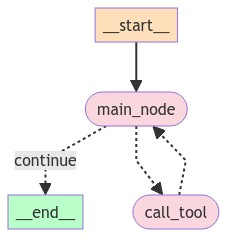

In [9]:
workflow = StateGraph(AgentState)
workflow.add_node("main_node", main_node)
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "main_node",
    router,
    {"continue": END, "call_tool": "call_tool"},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "main_node": "main_node"
    },
)

workflow.set_entry_point("main_node")
graph = workflow.compile()


#DRAW GRAPH
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [10]:
with open("Data/new/algorithm_problems_using_python__144__06_03_2024_15_46_55_1.ipynb", "r") as file:
    convo = file.read()

input_message = {
    "chat_history": [],
    "messages": [HumanMessage((f"Conversation between AI Assistant and a human User: \n {convo}"))],
    "user_config": {},
}


for s in graph.stream(input_message, {"recursion_limit": 20}):
    print("AGENT:", s)
    agent = list(s.keys())[0]
    content = s[agent]["messages"][-1].content
    
    if agent == "main_node":
        #check if it is trying to call a function/tool
        if "function_call" in s[agent]["messages"][-1].additional_kwargs:
            function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
            args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
            content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
            content = Markdown(content)
            md(content)
        else:
            try:
                content = str(json.loads(content))
            except:
                pass
            content = Markdown(content)
            md(content)
    else:
        content = Markdown(content)
        md(content)

AGENT: {'main_node': {'messages': [AIMessage(content='\n{\n  "scratchpad": "The code provided by the assistant includes a function to preprocess text and a function to find the longest palindrome using Manacher\'s Algorithm. The preprocessing function `preprocess_text` can be tested standalone without any external modules. The main function `manacher_longest_palindrome` can be tested as well.\\n\\nWe\'ll begin by testing the `preprocess_text` function. This function should convert all characters to lowercase and remove non-alphanumeric characters. We\'ll use two tests: one with a mix of upper and lower case letters and special characters, and another with only alphanumeric characters.\\n\\nNext, we\'ll test the `manacher_longest_palindrome` function. We\'ll use a simple test case with a well-known palindrome and another edge case with no palindromes.",\n  "issues": [],\n  "scoring_explanation": "The code provided by the assistant includes a preprocess function and the main function for

I am calling the function python_repl with the following arguments: { "code": "def preprocess_text(text):\n        
return ''.join(char.lower() for char in text if char.isalnum())\n\n# Test Cases\n# Happy                           
Path\nprint(preprocess_text('A man, a plan, a canal: Panama'))  # Expected: 'amanaplanacanalpanama'\n# Edge        
Case\nprint(preprocess_text('Hello123'))  # Expected: 'hello123'" }

AGENT: {'call_tool': {'messages': [FunctionMessage(content="python_repl response: Successfully executed:\n```python\ndef preprocess_text(text):\n    return ''.join(char.lower() for char in text if char.isalnum())\n\n# Test Cases\n# Happy Path\nprint(preprocess_text('A man, a plan, a canal: Panama'))  # Expected: 'amanaplanacanalpanama'\n# Edge Case\nprint(preprocess_text('Hello123'))  # Expected: 'hello123'\n```\nStdout: amanaplanacanalpanama\nhello123\n", name='python_repl')]}}


python_repl response: Successfully executed:                                                                       

                                                                                                                   
 def preprocess_text(text):                                                                                        
     return ''.join(char.lower() for char in text if char.isalnum())                                               
                                                                                                                   
 # Test Cases                                                                                                      
 # Happy Path                                                                                                      
 print(preprocess_text('A man, a plan, a canal: Panama'))  # Expected: 'amanaplanacanalpanama'                     
 # Edge Case                                                                                                       
 print(preprocess_text('Hello123'))  # Expected: 'hello123'                                                        
                                                                                                                   

Stdout: amanaplanacanalpanama hello123

AGENT: {'main_node': {'messages': [AIMessage(content='\n{\n  "scratchpad": "The `preprocess_text` function passed both test cases:\\n1. \'A man, a plan, a canal: Panama\' -> \'amanaplanacanalpanama\'\\n2. \'Hello123\' -> \'hello123\'\\n\\nNow, we can proceed to test the `manacher_longest_palindrome` function. We\'ll use one happy path and one edge case for this function as well. We\'ll modify the function slightly to accept a single string instead of a list of strings to simplify testing.",\n  "issues": [],\n  "scoring_explanation": "The `preprocess_text` function works correctly as demonstrated by the test cases. Moving on to test the main function for Manacher\'s Algorithm.",\n  "score": 4\n}', additional_kwargs={'function_call': {'arguments': '{"code":"def preprocess_text(text):\\n    return \'\'.join(char.lower() for char in text if char.isalnum())\\n\\n\\ndef manacher_longest_palindrome(text):\\n    text = preprocess_text(text)\\n    n = len(text)\\n    p = [0] * n\\n    longest_p

I am calling the function python_repl with the following arguments: {"code":"def preprocess_text(text):\n    return
''.join(char.lower() for char in text if char.isalnum())\n\n\ndef manacher_longest_palindrome(text):\n    text =   
preprocess_text(text)\n    n = len(text)\n    p = [0] * n\n    longest_palindrome = ""\n    longest_length = 0\n\n 
# Manacher's Algorithm\n    for i in range(n):\n        # Expand palindrome around center i (odd length)\n        j
= 0\n        while i - j >= 0 and i + j < n and text[i - j] == text[i + j]:\n            j += 1\n        p[i] = j -
1\n\n        # Update longest palindrome information\n        if p[i] * 2 + 1 > longest_length:\n                  
longest_length = p[i] * 2 + 1\n            longest_palindrome = text[i - p[i]:i + p[i] + 1]\n\n        # Expand    
palindrome around centers i and i+1 (even length)\n        j = 0\n        while i - j >= 0 and i + 1 + j < n and   
text[i - j] == text[i + 1 + j]:\n            j += 1\n        p[i] = max(p[i], j)\n\n        # Update longest       
palindrome information\n        if p[i] * 2 > longest_length:\n            longest_length = p[i] * 2\n             
longest_palindrome = text[i - p[i] + 1:i + p[i] + 1]\n\n    return longest_palindrome\n\n# Test Cases\n# Happy     
Path\nprint(manacher_longest_palindrome('A man, a plan, a canal: Panama'))  # Expected: 'amanaplanacanalpanama'\n# 
Edge Case\nprint(manacher_longest_palindrome('Hello'))  # Expected: 'll'"}

AGENT: {'call_tool': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\ndef preprocess_text(text):\n    return \'\'.join(char.lower() for char in text if char.isalnum())\n\n\ndef manacher_longest_palindrome(text):\n    text = preprocess_text(text)\n    n = len(text)\n    p = [0] * n\n    longest_palindrome = ""\n    longest_length = 0\n\n    # Manacher\'s Algorithm\n    for i in range(n):\n        # Expand palindrome around center i (odd length)\n        j = 0\n        while i - j >= 0 and i + j < n and text[i - j] == text[i + j]:\n            j += 1\n        p[i] = j - 1\n\n        # Update longest palindrome information\n        if p[i] * 2 + 1 > longest_length:\n            longest_length = p[i] * 2 + 1\n            longest_palindrome = text[i - p[i]:i + p[i] + 1]\n\n        # Expand palindrome around centers i and i+1 (even length)\n        j = 0\n        while i - j >= 0 and i + 1 + j < n and text[i - j] == text[i + 1 + j]:\n           

python_repl response: Successfully executed:                                                                       

                                                                                                                   
 def preprocess_text(text):                                                                                        
     return ''.join(char.lower() for char in text if char.isalnum())                                               
                                                                                                                   
                                                                                                                   
 def manacher_longest_palindrome(text):                                                                            
     text = preprocess_text(text)                                                                                  
     n = len(text)                                                                                                 
     p = [0] * n                                                                                                   
     longest_palindrome = ""                                                                                       
     longest_length = 0                                                                                            
                                                                                                                   
     # Manacher's Algorithm                                                                                        
     for i in range(n):                                                                                            
         # Expand palindrome around center i (odd length)                                                          
         j = 0                                                                                                     
         while i - j >= 0 and i + j < n and text[i - j] == text[i + j]:                                            
             j += 1                                                                                                
         p[i] = j - 1                                                                                              
                                                                                                                   
         # Update longest palindrome information                                                                   
         if p[i] * 2 + 1 > longest_length:                                                                         
             longest_length = p[i] * 2 + 1                                                                         
             longest_palindrome = text[i - p[i]:i + p[i] + 1]                                                      
                                                                                                                   
         # Expand palindrome around centers i and i+1 (even length)                                                
         j = 0                                                                                                     
         while i - j >= 0 and i + 1 + j < n and text[i - j] == text[i [38;2;255;70;137;48;2;39;40;3

AGENT: {'main_node': {'messages': [AIMessage(content='\n{\n  "scratchpad": "The `manacher_longest_palindrome` function passed both test cases:\\n1. \'A man, a plan, a canal: Panama\' -> \'amanaplanacanalpanama\'\\n2. \'Hello\' -> \'ll\'\\n\\nThe function works correctly and efficiently handles the preprocessing and palindrome detection.",\n  "issues": [],\n  "scoring_explanation": "The code provided by the assistant works correctly as demonstrated by the test cases. Both functions, `preprocess_text` and `manacher_longest_palindrome`, are correctly implemented and efficient. The explanation provided is clear and concise. Therefore, a score of 5 is appropriate.",\n  "score": 5\n}', response_metadata={'token_usage': {'completion_tokens': 151, 'prompt_tokens': 4330, 'total_tokens': 4481}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_927397958d', 'finish_reason': 'stop', 'logprobs': None}, id='run-23eb82e4-4cd1-4a35-8a0f-801c8c2afeb9-0')], 'sender': 'main_node'}}


{'scratchpad': "The manacher_longest_palindrome function passed both test cases:\n1. 'A man, a plan, a canal:      
Panama' -> 'amanaplanacanalpanama'\n2. 'Hello' -> 'll'\n\nThe function works correctly and efficiently handles the 
preprocessing and palindrome detection.", 'issues': [], 'scoring_explanation': 'The code provided by the assistant 
works correctly as demonstrated by the test cases. Both functions, preprocess_text and manacher_longest_palindrome,
are correctly implemented and efficient. The explanation provided is clear and concise. Therefore, a score of 5 is 
appropriate.', 'score': 5}

In [11]:
from IPython.display import display, HTML
import json

def pretty_print_html(data):
    # Convert the dictionary to a JSON string with indentation for readability
    pretty_data = json.dumps(data, indent=4)
    
    # Prepare HTML string with color styling
    html_data = '<pre style="line-height: 1.35;">'
    for line in pretty_data.splitlines():
        if ':' in line:
            key, value = line.split(':', 1)
            key = f'<span style="color: blue;">{key}</span>'
            if value.strip().startswith('"'):
                value = f'<span style="color: green;">{value}</span>'
            elif value.strip().isdigit():
                value = f'<span style="color: red;">{value}</span>'
            html_data += f"{key}:{value}\n"
        else:
            html_data += f'<span style="color: black;">{line}</span>\n'
    html_data += '</pre>'
    
    display(HTML(html_data))

agent = list(s.keys())[0]
content = json.loads(s[agent]["messages"][-1].content)
pretty_print_html(content)